### Reference mapping on COVID-19 dataset - Finetuning using Reference Dataset

We will use COVID-19 dataset to demonstrate the reference mapping. This notebook include finetuning process with reference dataset.
You can download the processed reference and query datasets from https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS. 
The COVID-19 dataset is derived from the work by Lotfollahi et al, which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cellama import lm_cell_reference_celltyping,lm_cell_embed , lm_cell_integrated_embed,lm_cell_reference_celltyping_nn,lm_cell_reference_celltyping_xgb

In [2]:
adata = sc.read_h5ad('./COVID19data/batch_covid_subsampled_train.h5ad')
test_adata = sc.read_h5ad('./COVID19data/batch_covid_subsampled_test.h5ad')


In [3]:
adata.var

,n_cells-0,n_cells-0-0-1,gene_ids-1-0-1,feature_types-1-0-1,genome-1-0-1,gene_name,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
HES4,50004,2230.0,ENSG00000188290,Gene Expression,GRCh38,HES4,55101.0,True,286.0,0.200845,1.115144,1.942989,13
ISG15,109957,47536.0,ENSG00000187608,Gene Expression,GRCh38,ISG15,1522599.0,True,247.0,5.549922,331.823947,2.526526,15
TNFRSF4,11423,1749.0,ENSG00000186827,Gene Expression,GRCh38,TNFRSF4,15332.0,True,438.0,0.055886,0.415313,2.280897,13
MXRA8,12495,17039.0,ENSG00000162576,Gene Expression,GRCh38,MXRA8,1464.0,True,421.0,0.005336,0.007225,1.216231,4
ATAD3A,24432,2926.0,ENSG00000197785,Gene Expression,GRCh38,ATAD3A,14495.0,True,435.0,0.052835,0.073430,1.058414,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGKJ1,2,2518.0,ENSG00000211597,Gene Expression,GRCh38,IGKJ1,861.0,True,67.0,0.003138,0.269231,0.342835,1
IGKV1D-12,27,109.0,ENSG00000278857,Gene Expression,GRCh38,IGKV1D-12,259.0,True,363.0,0.000944,0.020189,0.480225,2
IGKV1-27,199,855.0,ENSG00000244575,Gene Expression,GRCh38,IGKV1-27,21277.0,True,265.5,0.077555,306.821385,0.600276,2
APOA4,5,7605.0,ENSG00000110244,Gene Expression,GRCh38,APOA4,118.0,True,180.0,0.000430,0.001786,0.212682,1


In [4]:
adata.obs[['sample','disease','condition','sample_new','celltype']]

,sample,disease,condition,sample_new,celltype
483188-0-0-1,AdultBladder,nan,control,nan,Monocytes
P2_1_GGTGAAGAGAGAACAG_Krasnow-0-0,distal 2,nan,control,nan,AT2
513429-0-0-1,AdultPeripheralBlood,nan,control,nan,T cell
CCTACCACACTCTGTC-1-HCATisStab7659969_Meyer-1-0,368C_12h,nan,control,nan,CD4+ T cells
144-0-1-0-1,C100,nan,control,HC3,Macrophages
...,...,...,...,...,...
31534-0-0-1,AdultBoneMarrow,nan,control,nan,Neutrophil
20532-0-1-0-1,C143,nan,severe COVID-19,S2,Macrophages
222101-0-0-1,AdultTemporalLobe,nan,control,nan,Macrophages
31384-0-1-0-1,C145,nan,severe COVID-19,S1,Macrophages


### Tuning with sentence generator

In [5]:
from cellama_training import sentence_from_adata_generator, train_model_sentences

In [6]:
#Training Parameters
num_samples = 10000
top_k_values = [16, 20,24,28]
obs_features_options = [None,['condition']]
n_hvgs_s=[500,1200]#Already selected samples.

In [7]:
all_examples= sentence_from_adata_generator.generate_and_save_examples(adata, num_samples, top_k_values, obs_features_options,
                                                                       n_hvgs_s=n_hvgs_s, 
                                                                       save_file = 'adata_covid19_retrain.json', genename= 'gene_name', 
                                                                       verbose=True, return_examples=True)

Preprocessing data...


/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


........ 500 16 None
----sample examples----
Texts: ['Top genes are FTL, ACTB, CTSL, FTH1, CD74, SRGN, ISG15, SPP1, CCL2, HLA-DRA, SAT1, HLA-DRB1, HSP90AA1, CXCL8, CRIP1, and IL1B.', 'Top genes are FTL, FTH1, CTSL, CD74, CCL2, SPP1, ISG15, HLA-DRA, ACTB, SAT1, SRGN, CCL3L1, CCL8, HLA-DRB1, CCL3, and APOC1.'], Label: 0.8129180669784546
Texts: ['Top genes are HSP90AA1, FTL, TPSB2, ACTB, TPSAB1, GATA2, FTH1, HSPE1, RGS2, EGR1, SRGN, HSPA1B, SAT1, RGS1, PTGS2, and HSPA6.', 'Top genes are FTL, FTH1, CD74, HLA-DRA, APOC1, HLA-DRB1, FABP4, ACTB, CD52, S100A9, CRIP1, LYZ, FN1, SRGN, S100A8, and HSP90AA1.'], Label: -0.2806015610694885
Texts: ['Top genes are S100A8, IGKC, S100A9, IGHG2, IGHG1, IGKV4-1, JCHAIN, ACTB, S100A12, FTL, HSPE1, OLFM4, PTTG1, NME1, SRGN, and TK1.', 'Top genes are FTL, FTH1, APOC1, CD74, ACTB, CXCL10, FABP4, HLA-DRB1, HLA-DRA, LYZ, SAT1, CTSL, SRGN, ISG15, CD52, and MTRNR2L12.'], Label: -0.2611651122570038
		 train_exmaples generated
........ 500 16 ['condition']
----samp

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(


........ 1200 16 None
----sample examples----
Texts: ['Top genes are PTMA, NPM1, ACTB, HNRNPA1, FTL, S100A6, JUNB, SELL, CD52, SERBP1, ACTG1, TUBA1B, FTH1, GAPDH, LTB, and RGS2.', 'Top genes are GZMB, CCL5, S100A4, IL32, ACTB, FTH1, SRGN, NKG7, ALOX5AP, S100A6, CD52, ACTG1, ID2, CST7, FTL, and KLRD1.'], Label: 0.2585691809654236
Texts: ['Top genes are FTL, FTH1, CRIP1, LYZ, S100A6, MT2A, ACTB, CD74, S100A11, TYROBP, APOC1, HLA-DRA, S100A4, LGALS1, CD52, and C1QA.', 'Top genes are FTL, FTH1, CRIP1, APOC1, S100A6, CD74, LYZ, S100A4, S100A11, ACTB, CCL18, HLA-DRA, MT2A, TYROBP, FABP4, and C1QB.'], Label: 0.9656957983970642
Texts: ['Top genes are FTL, HLA-DRA, CCL2, MRC1, THBS1, HLA-DPB1, HLA-DRB1, ZFP36, C1QA, PTGDS, HSPA8, NFKBIA, HSPD1, FBLN1, KLF10, and CXCL8.', 'Top genes are S100A6, TUBB4B, CD74, HSP90AA1, IFI27, SLPI, FTH1, GSTA1, S100A11, WFDC2, IFI6, LGALS3, GSTP1, CLU, ANXA2, and TSPAN1.'], Label: -0.044721782207489014
		 train_exmaples generated
........ 1200 16 ['condition']
--

In [8]:
#If we want to use pre-defined sentences
from _examples_to_json import load_examples_from_json
all_examples = load_examples_from_json('./sentence_examples/adata_covid19_retrain.json')

In [9]:
len(all_examples)

159872

In [48]:
output_path = './finetune_model/covid19'
train_model_sentences.train_model(all_examples, output_path, backcbone_model = 'all-MiniLM-L12-v2',
            epochs=1, batch_size=32, evaluation_steps=1000, validation_size=1000,learning_rate=1e-5)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4965 [00:00<?, ?it/s]

In [49]:
adata_emb=  lm_cell_embed(adata, top_k=16, model_name="all-MiniLM-L6-v2",
                          gene_list=None, obs_features=None,
                         return_sentence=True)

/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:95: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_emb = sc.AnnData(emb_res)


In [50]:
adata_emb_finetune = lm_cell_embed(adata, top_k=16, model_name="finetune_model/covid19",
                          gene_list=None, obs_features=['condition'],
                         return_sentence=True)

/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:95: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_emb = sc.AnnData(emb_res)


/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

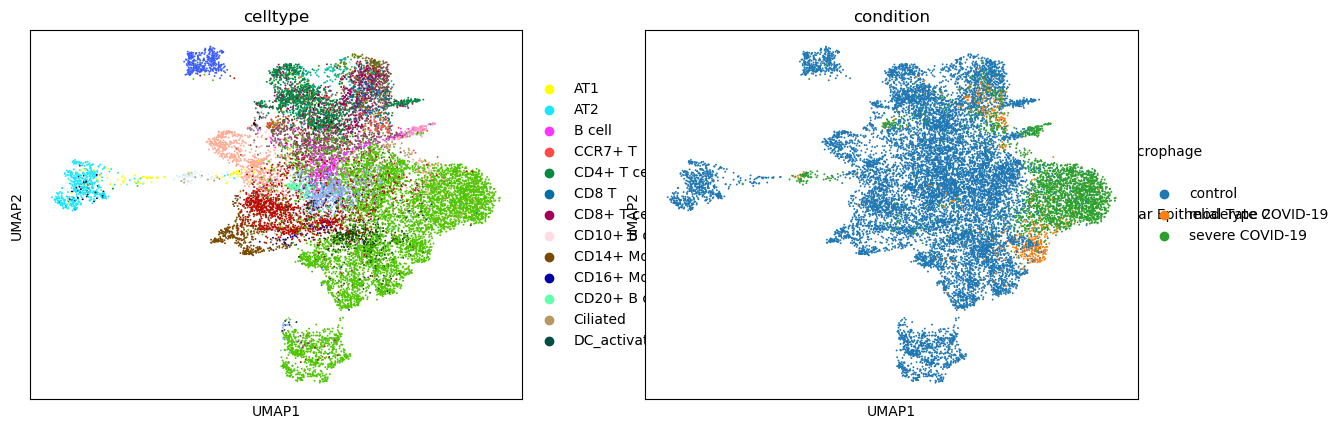

In [51]:
sc.pl.umap(adata_emb, color=['celltype','condition'])

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

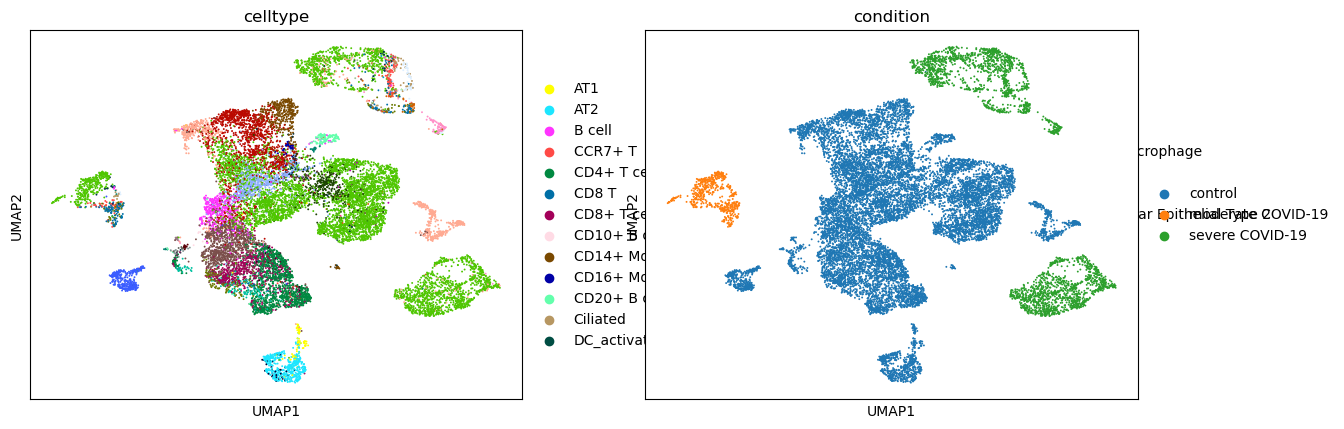

In [52]:
sc.pl.umap(adata_emb_finetune, color=['celltype','condition'])

In [53]:
print(adata_emb_finetune.obs['cell_sentence'][0])

Top genes are CST3, COTL1, LGALS3, VIM, CCL3, CCL4L2, MGST1, SRGN, TYROBP, CTSS, GZMH, IL1B, TKT, HSP90AA1, RNF145, and TMEM176B. condition of this cell is control.


/tmp/ipykernel_1371694/2062509461.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(adata_emb_finetune.obs['cell_sentence'][0])


### Integration Test

In [54]:
adata_emb, adata_test_emb = lm_cell_integrated_embed(adata, test_adata, 
                                                     model_name="finetune_model/covid19",
                                                     top_k=16, use_intersect= True)

Language Model Cell Embedding Is Implemented


/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:177: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_emb = sc.AnnData(emb_res)
/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:181: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_emb_new = sc.AnnData(emb_res_new)


In [55]:
adata_all =sc.concat(
    [adata_emb, adata_test_emb],
    join='outer', label ='Batch',
)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [56]:
sc.tl.pca(adata_all, svd_solver='arpack')
sc.pp.neighbors(adata_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_all)

/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

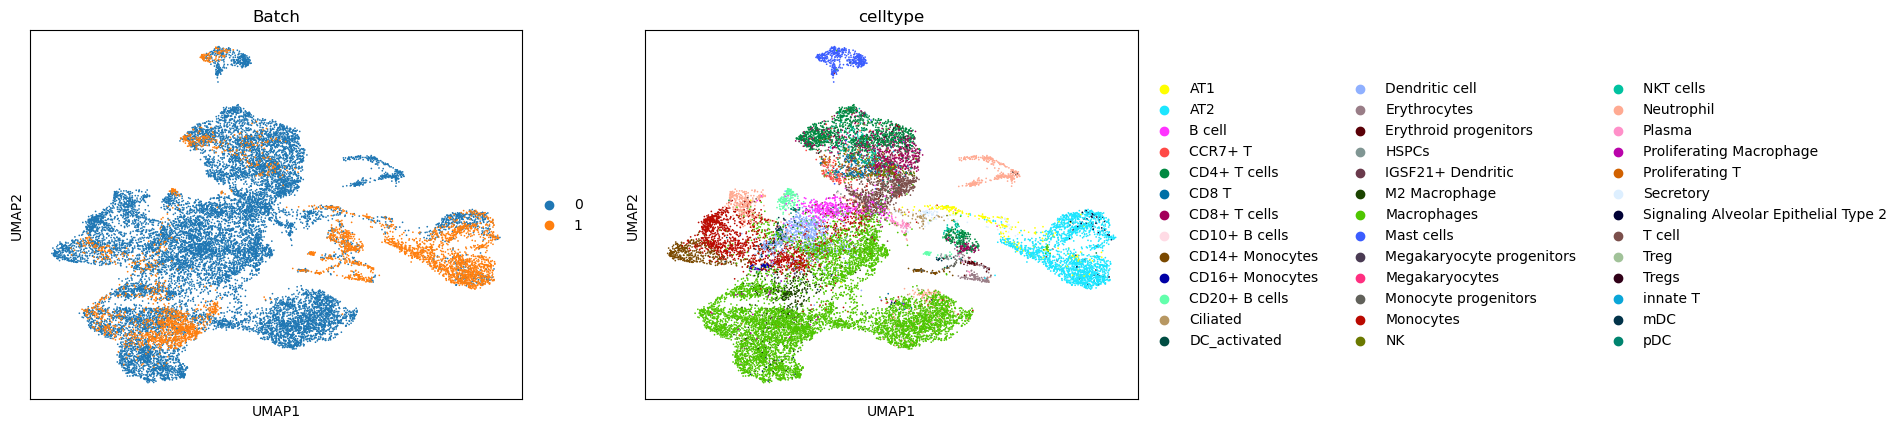

In [57]:
sc.pl.umap(adata_all, color=['Batch', 'celltype'])

### Cell labeling - kNN and Neural Network-based

In [58]:
adata_test_label = lm_cell_reference_celltyping(adata, test_adata, top_k=20, use_intersect= True, 
                                                model_name='finetune_model/covid19',
                                           ref_cell = 'celltype', new_name='cell_type_LM',obs_features = ['sample','condition'])

Language Model Cell Embedding Is Implemented


/home/user/DATA1/Data/Xenium_lungcancer_10xdata/cellama.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nearest_cell_types = [cell_types[i[0]] for i in indices]


In [59]:
#kNN-based
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
res_dict = {
    "accuracy": accuracy_score(adata_test_label.obs['celltype'], adata_test_label.obs['cell_type_LM']),
    "precision": precision_score(adata_test_label.obs['celltype'], adata_test_label.obs['cell_type_LM'], average="macro"),
    "recall": recall_score(adata_test_label.obs['celltype'], adata_test_label.obs['cell_type_LM'], average="macro"),
    "macro_f1": f1_score(adata_test_label.obs['celltype'], adata_test_label.obs['cell_type_LM'], average="macro"),
}

print(res_dict)

{'accuracy': 0.8666000499625282, 'precision': 0.6100414190965505, 'recall': 0.5954904255390085, 'macro_f1': 0.5650400445095449}


/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/lang/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
adata_test_label_xgb= lm_cell_reference_celltyping_xgb(adata, test_adata, top_k=16, use_intersect= True, model_name='finetune_model/covid19',
                                                        ref_cell = 'celltype', new_name='cell_type_LM',obs_features = ['sample','condition'])

In [ ]:
res_dict_xgb = {
    "accuracy": accuracy_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM']),
    "precision": precision_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM'], average="macro"),
    "recall": recall_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM'], average="macro"),
    "macro_f1": f1_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM'], average="macro"),
}

print(res_dict_xgb)

In [ ]:
### Grid Search
from tqdm import tqdm
from itertools import product

def grid_search(adata, test_adata):
    # Define the parameter grid
    param_grid = {
        'top_k': np.linspace(10,30, 11, dtype=int),  # 10 values from 20 to 200
        'model_name': ['all-MiniLM-L12-v2'],
        'obs_features': [['sample'],['condition'],['sample','condition'], None]
    }

    # Create a product of all parameter combinations
    all_combinations = list(product(param_grid['top_k'], param_grid['model_name'], param_grid['obs_features']))
    
    results = []

    # Use tqdm to show progress
    for top_k, model_name, obs_features in tqdm(all_combinations, desc='Grid Search Progress', unit='combination'):
        try:
            # Run the cell typing function
            adata_test_label_xgb = lm_cell_reference_celltyping(
                adata, test_adata,
                top_k=top_k,
                use_intersect=True,
                model_name=model_name,
                ref_cell='celltype',
                new_name='cell_type_LM',
                obs_features=obs_features
            )

            # Calculate metrics
            metrics = {
                "accuracy": accuracy_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM']),
                "precision": precision_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM'], average="macro"),
                "recall": recall_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM'], average="macro"),
                "macro_f1": f1_score(adata_test_label_xgb.obs['celltype'], adata_test_label_xgb.obs['cell_type_LM'], average="macro"),
            }
            
            # Store results
            results.append({
                'top_k': top_k,
                'model_name': model_name,
                'obs_features': ','.join(obs_features) if obs_features else 'None',
                'metrics': metrics
            })
            
            print('RESULTS',{
                'top_k': top_k,
                'model_name': model_name,
                'obs_features': ','.join(obs_features) if obs_features else 'None',
                'metrics': metrics
            })

        except Exception as e:
            print(f"Error with parameters top_k={top_k}, model_name={model_name}, obs_features={obs_features}: {str(e)}")

    return results

results = grid_search(adata, test_adata)

In [22]:
df_results = pd.DataFrame(results)

df_results['accuracy'] = df_results['metrics'].apply(lambda x: x['accuracy'])
df_results['precision'] = df_results['metrics'].apply(lambda x: x['precision'])
df_results['recall'] = df_results['metrics'].apply(lambda x: x['recall'])
df_results['macro_f1'] = df_results['metrics'].apply(lambda x: x['macro_f1'])


In [23]:
df_results

,top_k,model_name,obs_features,metrics,accuracy,precision,recall,macro_f1
0,10,all-MiniLM-L12-v2,sample,"{'accuracy': 0.8368723457406945, 'precision': ...",0.836872,0.402903,0.373296,0.362261
1,10,all-MiniLM-L12-v2,condition,"{'accuracy': 0.7729203097676742, 'precision': ...",0.772920,0.404255,0.396798,0.369444
2,10,all-MiniLM-L12-v2,"sample,condition","{'accuracy': 0.8343742193354984, 'precision': ...",0.834374,0.425731,0.406483,0.395400
3,10,all-MiniLM-L12-v2,None,"{'accuracy': 0.7816637521858606, 'precision': ...",0.781664,0.377689,0.359494,0.338988
4,12,all-MiniLM-L12-v2,sample,"{'accuracy': 0.8396202847864102, 'precision': ...",0.839620,0.464074,0.427265,0.409127
5,12,all-MiniLM-L12-v2,condition,"{'accuracy': 0.7771671246565076, 'precision': ...",0.777167,0.432499,0.401890,0.391655
6,12,all-MiniLM-L12-v2,"sample,condition","{'accuracy': 0.8363727204596553, 'precision': ...",0.836373,0.456102,0.434386,0.416674
7,12,all-MiniLM-L12-v2,None,"{'accuracy': 0.7864101923557332, 'precision': ...",0.786410,0.396381,0.373789,0.361029
8,14,all-MiniLM-L12-v2,sample,"{'accuracy': 0.8388708468648514, 'precision': ...",0.838871,0.445607,0.435794,0.407957
9,14,all-MiniLM-L12-v2,condition,"{'accuracy': 0.792905321009243, 'precision': 0...",0.792905,0.441401,0.441364,0.407124


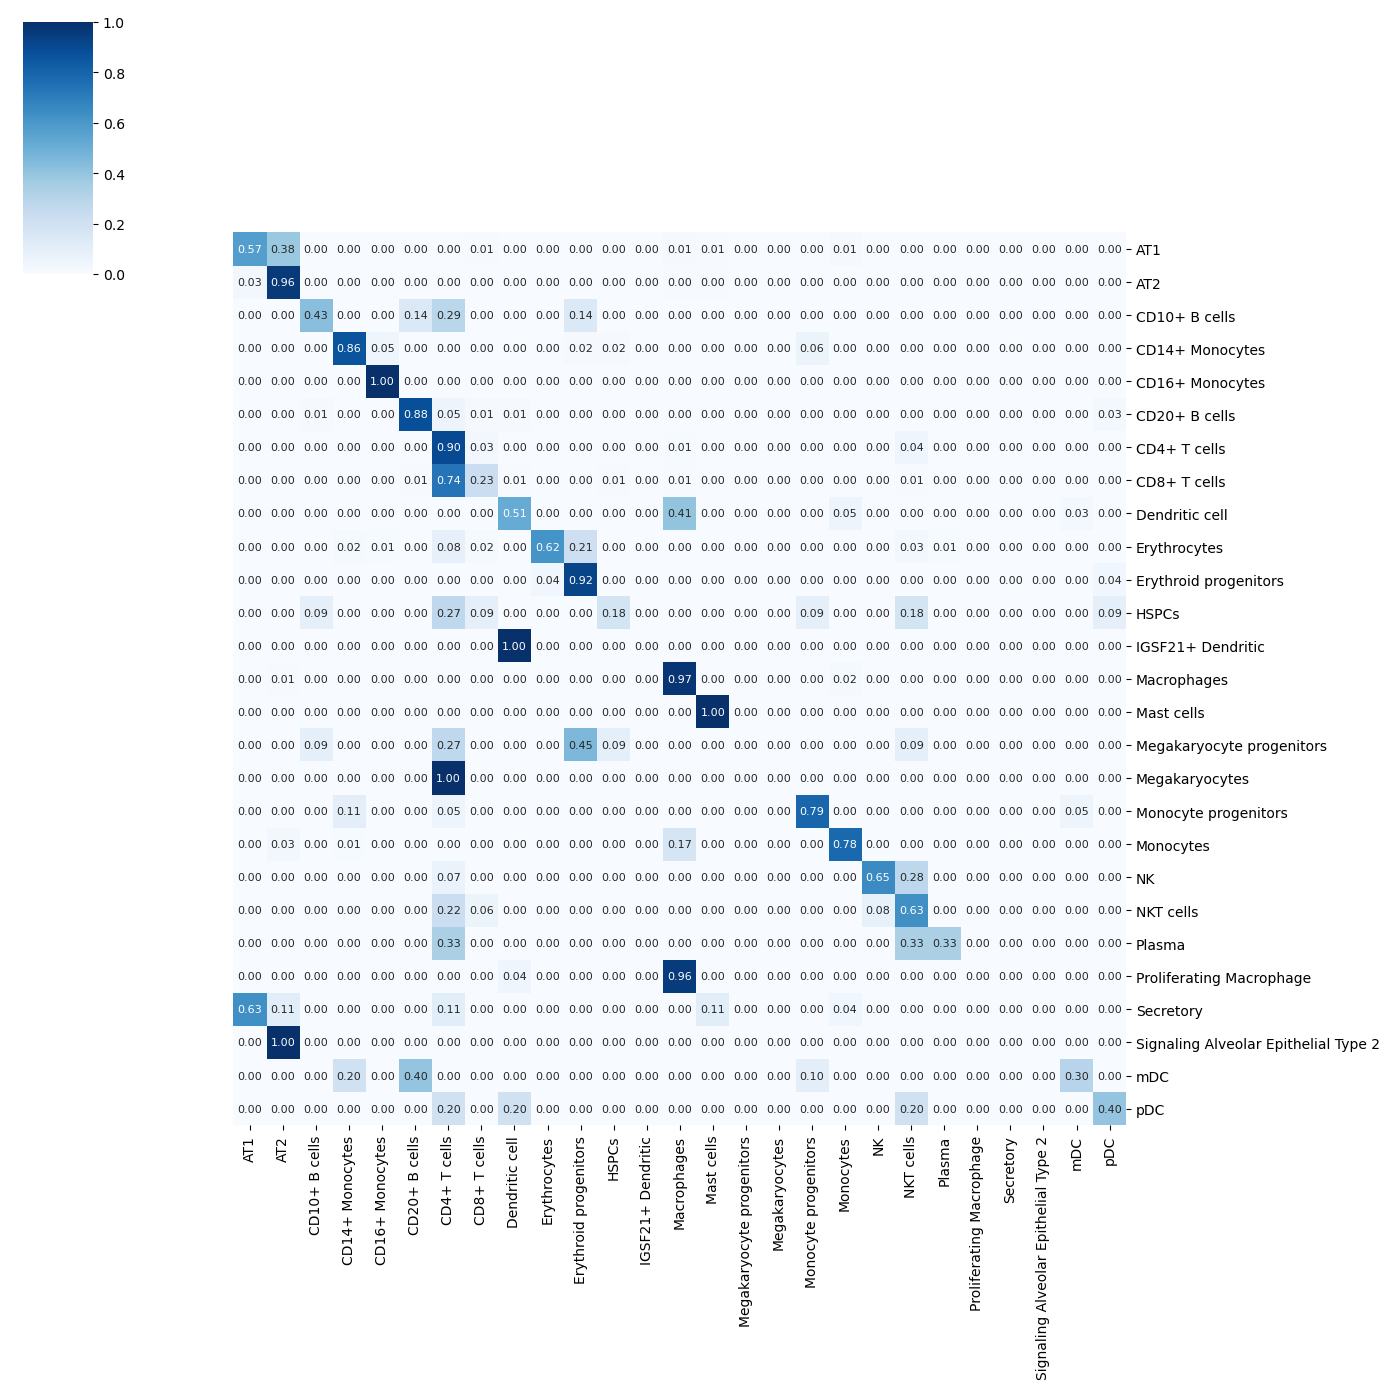

In [21]:
from sklearn.metrics import confusion_matrix

y_true = adata_test_label_xgb.obs['celltype']
y_pred = adata_test_label_xgb.obs['cell_type_LM']
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])
ax = sns.clustermap(df,  
                    cmap='Blues',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

##### cf>scGPT results
{'accuracy': 0.8668498626030477,
 'precision': 0.5449474091628096,
 'recall': 0.49698960480359766,
 'macro_f1': 0.483531805052145}

/tmp/ipykernel_1166257/3969727792.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_none = df_none.append(zeroshot_results, ignore_index=True)


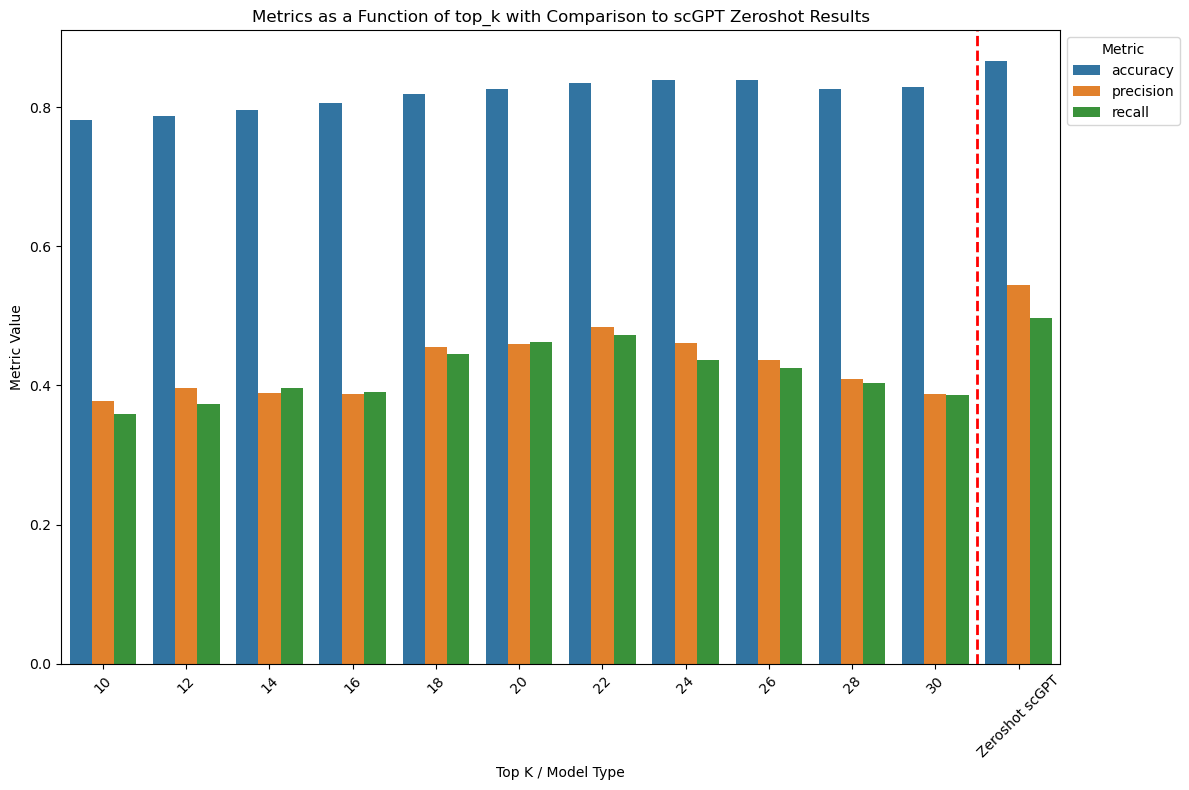

In [35]:
df_none = df_results[df_results['obs_features'] == 'None']
zeroshot_results = {
    "top_k": "Zeroshot scGPT",  # Unique identifier
    "model_name": "none",
    "obs_features": "None",
    "accuracy": 0.8668498626030477,
    "precision": 0.5449474091628096,
    "recall": 0.49698960480359766,
    "macro_f1": 0.483531805052145
}

df_none = df_none.append(zeroshot_results, ignore_index=True)


# Melt the DataFrame to make it suitable for seaborn's barplot
df_melted = df_none.melt(id_vars=['top_k'], value_vars=['accuracy', 'precision', 'recall'],
                         var_name='Metric', value_name='Value')

# Create a barplot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
barplot = sns.barplot(x='top_k', y='Value', hue='Metric', data=df_melted, palette="tab10")

# Highlight the scGPT zeroshot results
# Find the index for scGPT results to draw a vertical line
scgpt_index = df_melted.index[df_melted['top_k'] == 'Zeroshot scGPT'].tolist()[0]
plt.axvline(x=scgpt_index - 0.5, color='red', linestyle='--', linewidth=2)  # Adjusting x position for aesthetics

plt.title('Metrics as a Function of top_k with Comparison to scGPT Zeroshot Results')
plt.xlabel('Top K / Model Type')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Adjust layout to make room for legend and x-axis labels
plt.show()

/tmp/ipykernel_1166257/766232162.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_obs = df_obs.append(zeroshot_results, ignore_index=True)


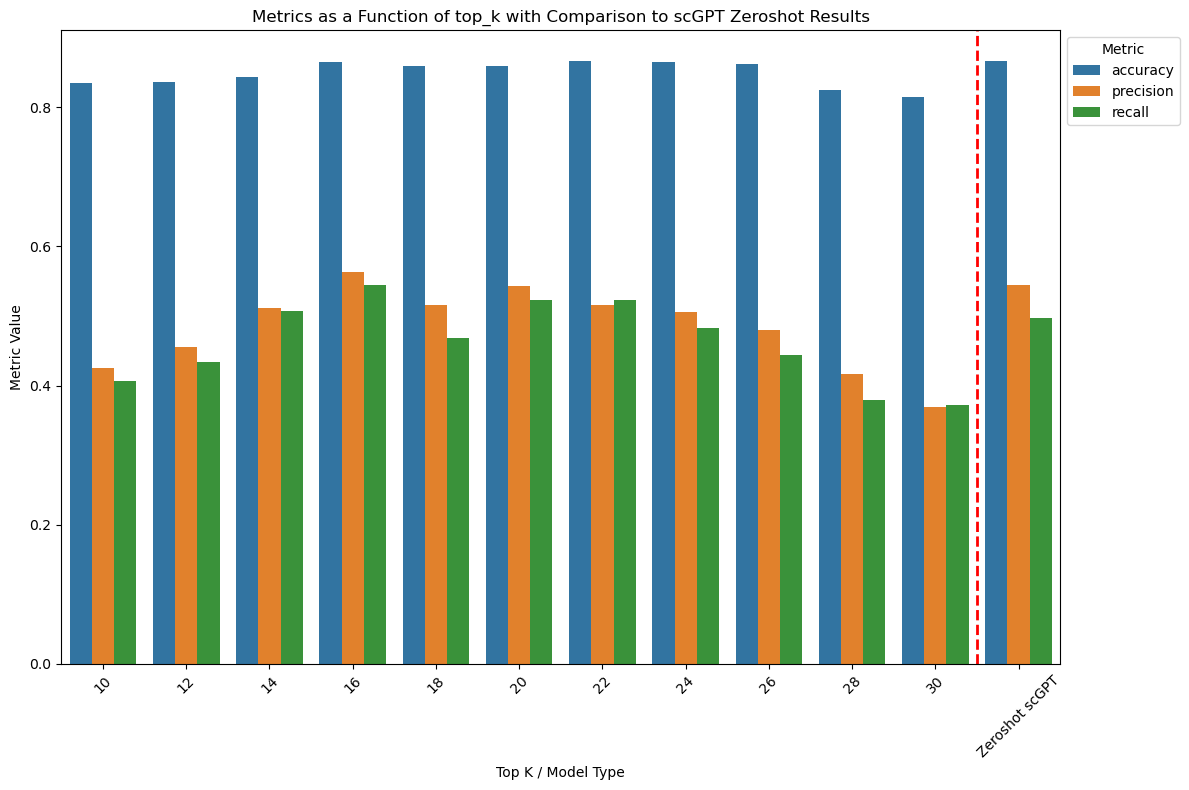

In [36]:
df_obs = df_results[df_results['obs_features'] == 'sample,condition']
zeroshot_results = {
    "top_k": "Zeroshot scGPT",  # Unique identifier
    "model_name": "none",
    "obs_features": "sample,condition",
    "accuracy": 0.8668498626030477,
    "precision": 0.5449474091628096,
    "recall": 0.49698960480359766,
    "macro_f1": 0.483531805052145
}

df_obs = df_obs.append(zeroshot_results, ignore_index=True)


# Melt the DataFrame to make it suitable for seaborn's barplot
df_melted = df_obs.melt(id_vars=['top_k'], value_vars=['accuracy', 'precision', 'recall'],
                         var_name='Metric', value_name='Value')

# Create a barplot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
barplot = sns.barplot(x='top_k', y='Value', hue='Metric', data=df_melted, palette="tab10")

# Highlight the scGPT zeroshot results
# Find the index for scGPT results to draw a vertical line
scgpt_index = df_melted.index[df_melted['top_k'] == 'Zeroshot scGPT'].tolist()[0]
plt.axvline(x=scgpt_index - 0.5, color='red', linestyle='--', linewidth=2)  # Adjusting x position for aesthetics

plt.title('Metrics as a Function of top_k with Comparison to scGPT Zeroshot Results')
plt.xlabel('Top K / Model Type')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Adjust layout to make room for legend and x-axis labels
plt.show()